We train a random forest from the dataset that we had saved in a previous notebook.

In [1]:
from fastai.tabular.all import *

comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)

to = load_pickle(path/'to.pkl')
dep_var = 'SalePrice'

We define a function to instantiate and train a random forest with more appropriate defaults, and execute it.

In [2]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [3]:
m = rf(to.train.xs, to.train.y);

We define the loss, for reuse.

In [4]:
def r_mse(x, y):
    return round(math.sqrt(((x - y)**2).mean()), 6)

We evaluate the losses.

In [5]:
r_mse(m.predict(to.train.xs), to.train.y), r_mse(m.predict(to.valid.xs), to.valid.y)

(0.171221, 0.232004)

An important property of random forest is that they are not very sensitive to hyperparameter choices.

Below we illustrate how our predictions improve with the numger of trees. First, we verify that we obtain the same loss if we use the full complement of trees.

In [6]:
import numpy as np

preds = np.stack([t.predict(to.valid.xs) for t in m.estimators_])


/home/jhanschoo/.local/share/hatch/env/virtual/fai/Rcp_9cR7/fastbook/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/jhanschoo/.local/share/hatch/env/virtual/fai/Rcp_9cR7/fastbook/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/jhanschoo/.local/share/hatch/env/virtual/fai/Rcp_9cR7/fastbook/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/jhanschoo/.local/share/hatch/env/virtual/fai/Rcp_9cR7/fastbook/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/jhanschoo/.local/share/hat

In [7]:
r_mse(preds.mean(0), to.valid.y)

0.232004

We now plot how it changes in the number of trees in the ensemble.

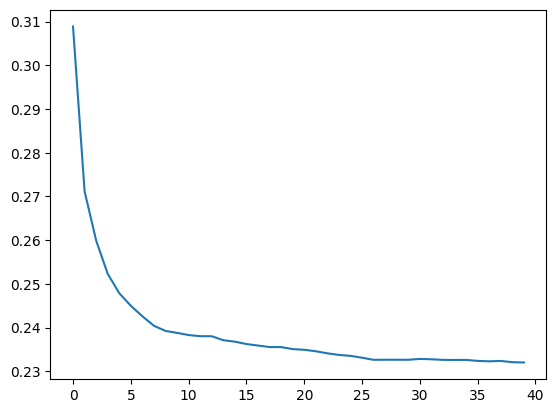

In [8]:
import matplotlib.pyplot as plt

plt.plot([r_mse(preds[:i+1].mean(0), to.valid.y) for i in range(40)])

We can access the OOB error of a random forest as follows.

In [9]:
r_mse(m.oob_prediction_, to.train.y)

0.211083

Recall the individual trees' predictions.

In [10]:
preds.shape

(40, 7988)

Let us get the per-auction standard deviation of the predictions over all the trees as follows, and then view the SDs of the first 5 auctions.

In [11]:
preds_std = preds.std(0)
preds_std[:5]

array([0.24717549, 0.10659487, 0.11029252, 0.26095832, 0.16525459])

The model also informs us how important each feature is.

In [12]:
fi = pd.DataFrame({ 'cols': to.train.xs.columns, 'imp': m.feature_importances_ }).sort_values('imp', ascending=False)
fi[:10]

,cols,imp
57,YearMade,0.171647
30,Coupler_System,0.101240
6,ProductSize,0.096885
7,fiProductClassDesc,0.087323
54,ModelID,0.058275
65,saleElapsed,0.051531
32,Hydraulics_Flow,0.051284
3,fiSecondaryDesc,0.047659
31,Grouser_Tracks,0.042836
12,Enclosure,0.035428


And we can plot the relative importances.

<Axes: ylabel='cols'>

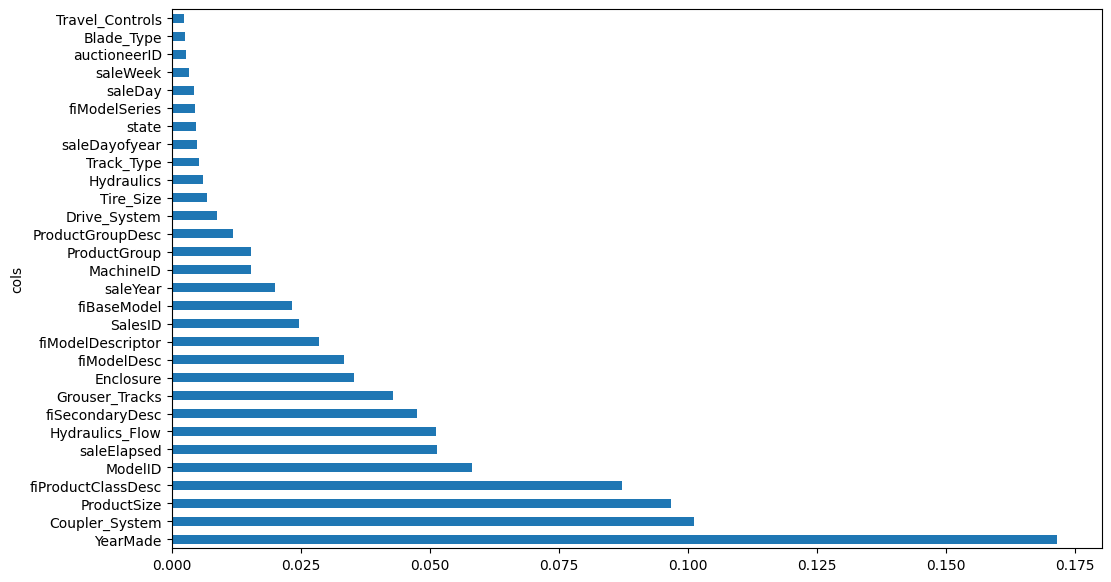

In [13]:
fi[:30].plot(
    'cols', 'imp', 'barh', figsize=(12, 7), legend=False
)

We now consider discarding the low-importance features.

In [14]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

22

In [15]:
xs_imp = to.train.xs[to_keep]
valid_xs_imp = to.valid.xs[to_keep]

In [16]:
m = rf(xs_imp, to.train.y)

In [17]:
r_mse(m.predict(xs_imp), to.train.y), r_mse(m.predict(valid_xs_imp), to.valid.y)

(0.181187, 0.230486)

We reiterate how much fewer columns we have now.

In [18]:
len(to.train.xs.columns), len(xs_imp.columns)

(66, 22)

We plot the feature importance of this model.

<Axes: ylabel='cols'>

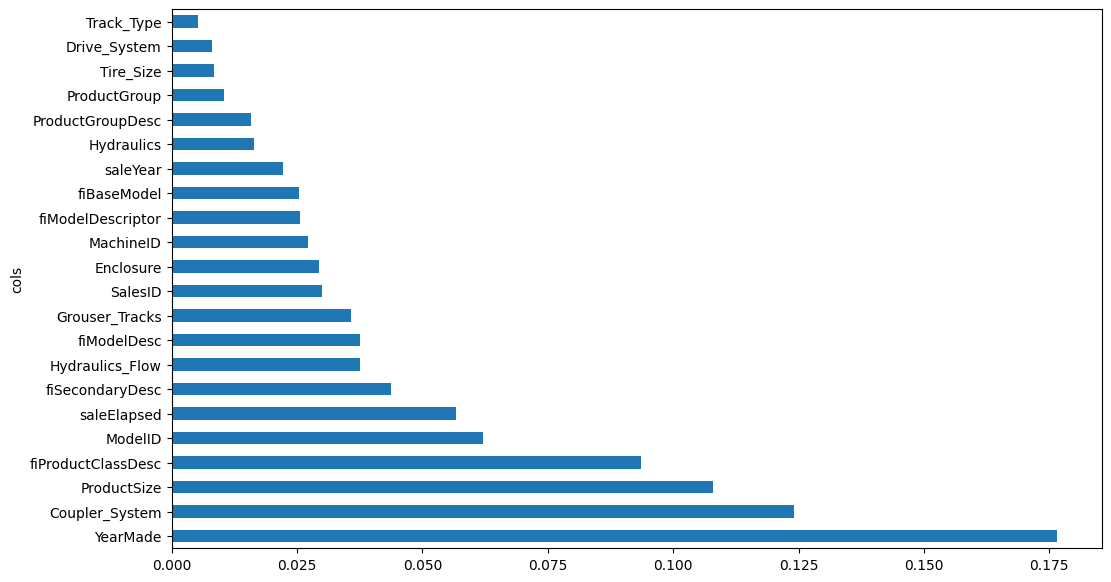

In [19]:
pd.DataFrame({ 'cols': xs_imp.columns, 'imp': m.feature_importances_ }).sort_values('imp', ascending=False).plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

Moreover, some features are correlated to the extent that they are redundant. We generate models omitting one column or another and look at the oob scores to see whech are likely to be redundant.

In [20]:
def get_oob(df, y):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here is the baseline.

In [21]:
get_oob(xs_imp, to.train.y)


0.875683654699832

And the oob scores dropping some candidate redundant columns individually.

In [22]:
{ c: get_oob(xs_imp.drop(c, axis=1), to.train.y) for c in (
    'saleYear', 'saleElapsed', 'ProductGroup',
    'fiModelDesc', 'fiBaseModel', 'ProductGroupDesc',
    'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System') }


{'saleYear': 0.8734740139644264,
 'saleElapsed': 0.8705402680708144,
 'ProductGroup': 0.8755045510904877,
 'fiModelDesc': 0.8746985492018047,
 'fiBaseModel': 0.8749926378631456,
 'ProductGroupDesc': 0.8757062918800983,
 'Hydraulics_Flow': 0.8756152103128635,
 'Grouser_Tracks': 0.8763263169846323,
 'Coupler_System': 0.8758909628154747}

In [23]:
get_oob(xs_imp.drop(['Hydraulics_Flow', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks'], axis=1), to.train.y)

0.8750697358139747

This looks good, so we save these pruned rows.

In [24]:
xs_final = xs_imp.drop(['Hydraulics_Flow', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks'], axis=1)
valid_xs_final = valid_xs_imp.drop(['Hydraulics_Flow', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks'], axis=1)

In [25]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)
save_pickle(path/'y_final.pkl', to.train.y)
save_pickle(path/'valid_y_final.pkl', to.valid.y)

Finally we have a look at the losses.

In [26]:
m = rf(xs_final, to.train.y)
r_mse(m.predict(xs_final), to.train.y), r_mse(m.predict(valid_xs_final), to.valid.y)

(0.181491, 0.232902)